In [94]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat 

In [212]:
B = 512;C = 10000;W = 1.4 * pow(10,6)
#w_I = w_M = pow(10,-30)
f_I = pow(10,12);f_M = pow(10,12)
N_0 = pow(10,-16);P = 0.5 

def arrival_and_departure_times(param1,param2,N):
    a = []
    d = []
    s = 0
    for i in range(N):
        s = s + np.random.exponential(param1)
        a.append(s)
    for i in range(N):
        d.append(a[i] + np.random.exponential(param2))
    return (np.array(a),np.array(d))

def local_cost():
    return ((B*C)/f_I)

def cloud_cost(n):
    h_g_2 = np.random.exponential(0.19)
    R = W * np.log2(1 + P*h_g_2/N_0)
    return (B/R + B*C*n/f_M)

def next_state(local_pos,cloud_pos,action):
    if action == 0:
        (new_local_pos,new_cloud_pos,reward) = (local_pos + 1,cloud_pos,-local_cost())
    else:
        (new_local_pos,new_cloud_pos,reward) = (local_pos,cloud_pos + 1,-cloud_cost(cloud_pos))
    return  (new_local_pos,new_cloud_pos,reward)


In [213]:
local_cost()

5.12e-06

In [202]:
print(cloud_cost(5))
print(cloud_cost(5))
print(cloud_cost(5))
print(cloud_cost(1))
print(cloud_cost(1))
print(cloud_cost(1))

3.2840944927992336e-05
3.295353584261593e-05
3.318323593648025e-05
1.2857053318147297e-05
1.3049235274447004e-05
1.3152649060791306e-05


In [214]:
def Server_Q_learning():
    N = 1000
    gamma = 0.5
    n = 50
    reward_list = []
    reward_sum_list = []
    reward_sum = 0
    count = 0
    mu = 1/20;lamda = 1
    Qa = np.zeros((n,n,2))
    freq = np.ones((n,n))
    freq_action = np.ones((n,n,2))
    (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
    local_pos = 0;cloud_pos = 0
    for ind in range(100):
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            reward_sum = reward_sum + reward
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*np.max(Qa[new_local_pos,new_cloud_pos]) - Qa[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
        reward_sum_list.append(reward_sum/count)
    return reward_list,reward_sum_list,local_actions

In [215]:
reward_list,rewardsum_list,local_actions = Server_Q_learning()

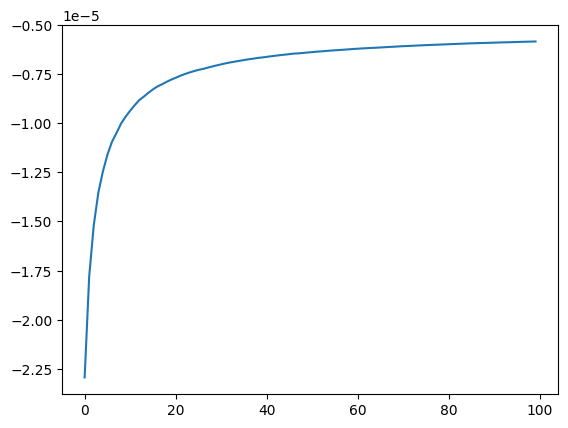

In [216]:
plt.plot(rewardsum_list)

In [217]:
def Server_DoubleQ_learning():
    N = 500
    gamma = 0.5
    n = 50
    reward_list = []
    reward_sum_list = []
    reward_sum = 0
    count = 0
    mu = 1/20;lamda = 1
    Qa = np.zeros((n,n,2))
    Qb = np.zeros((n,n,2))
    freq = np.ones((n,n))
    freq_action = np.ones((n,n,2))
    (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
    local_pos = 0;cloud_pos = 0
    for ind in range(100):
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
                        
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            if np.random.choice([True,False]):
                action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            else:
                action = np.random.choice([np.argmax(Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            reward_sum = reward_sum + reward
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            if np.random.choice([True,False]):
                Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qb[local_pos,cloud_pos,np.argmax(Qa[new_local_pos,new_cloud_pos])] - Qa[local_pos,cloud_pos,action])
            else:
                Qb[local_pos,cloud_pos,action] = Qb[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qa[local_pos,cloud_pos,np.argmax(Qb[new_local_pos,new_cloud_pos])] - Qb[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
        reward_sum_list.append(reward_sum/count)
    return reward_list,reward_sum_list,local_actions

In [218]:
r_list,r_sum_list,local_actions = Server_DoubleQ_learning()

In [219]:
len(r_list)

50000

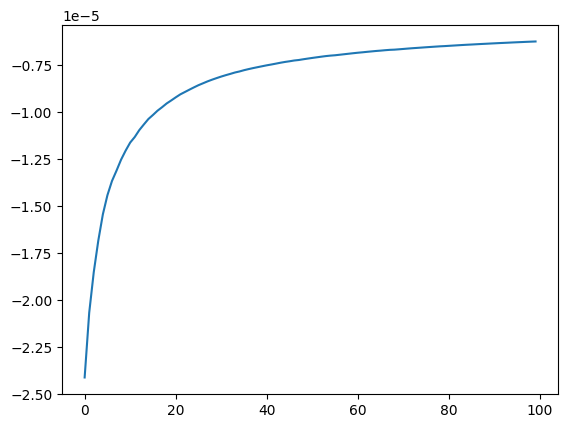

In [220]:
plt.plot(r_sum_list)

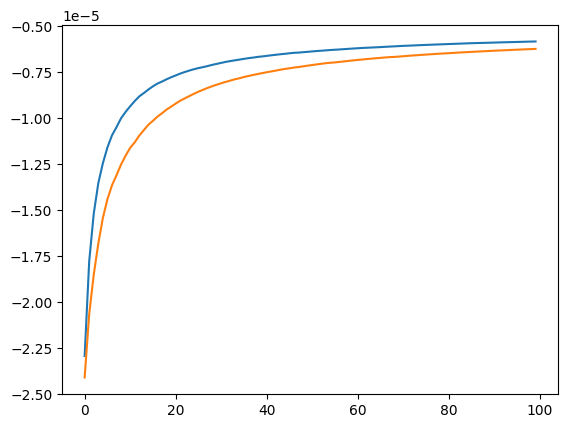

In [221]:
plt.plot(rewardsum_list)
plt.plot(r_sum_list)

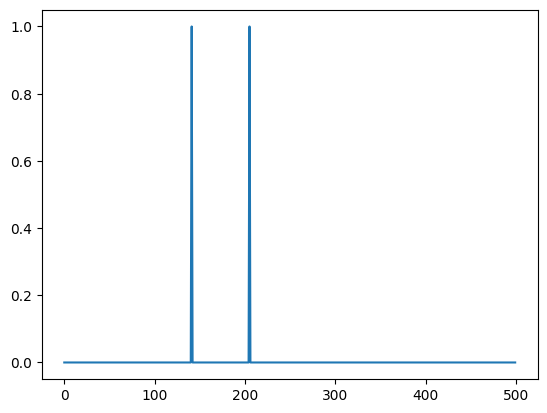

In [161]:
plt.plot(local_actions)

In [21]:
def Server_SwithcQ_learning():
    N = 500
    gamma = 0.5
    n = 30
    reward_list = []
    reward_sum_list = []
    reward_sum = 0
    count = 0
    mu = 1;lamda = 1
    Qa = np.zeros((n,n,2))
    Qb = np.zeros((n,n,2))
    freq = np.ones((n,n))
    freq_action = np.ones((n,n,2))
    (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
    local_pos = 0;cloud_pos = 0
    for ind in range(100):
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
                        
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            if np.random.choice([True,False]):
                action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            else:
                action = np.random.choice([np.argmax(Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            reward_sum = reward_sum + reward
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            if np.random.choice([True,False]):
                Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qb[local_pos,cloud_pos,np.argmax(Qa[new_local_pos,new_cloud_pos])] - Qa[local_pos,cloud_pos,action])
            else:
                Qb[local_pos,cloud_pos,action] = Qb[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qa[local_pos,cloud_pos,np.argmax(Qb[new_local_pos,new_cloud_pos])] - Qb[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
        reward_sum_list.append(reward_sum/count)
    return reward_list,reward_sum_list,local_actions

-0.029353674772470403

In [22]:
if(len(return_dict[local_pos,server_pos,action]) >= 2):
                if(np.var(return_dict[local_pos,server_pos,action]) < np.var(return_dict[local_pos,server_pos,1 - action])):

0.9798591747209238

In [110]:
np.random.exponential(0.19)

0.10953300922948625